In [19]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

In [20]:
from qiskit import IBMQ
IBMQ.load_account()
IBMQ.providers()

ibmqfactory.load_account:WARNING:2022-10-15 13:49:03,369: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-nus', group='default', project='default')>]

In [21]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQSimulator('simulator_mps') from IBMQ(hu

In [22]:
backend = provider.get_backend('ibm_perth')

In [23]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [24]:
dt = backend_config.dt # Example way of getting data on the backend
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [25]:
backend_defaults = backend.defaults() 
# backend.defaults() provides a starting point for using the backend, contains estimates for qubit frequencies and default programs to run basic operators

Frequency Sweep for Qubit Frequency

In [26]:
import numpy as np

# unit conversion factors cuz all backend results are returned in SI
GHz = 1.0e9
MHz = 1.0e6
us = 1.0e-6
ns = 1.0e-9

qubit = 0 # This will be the qubit number we use, this can vary from 0 to n - 1 correlating to the n qubits available in the backend

mem_slot = 0 # We define a memory slot channel, for all measured results from this qubit to go to

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz as of now, might change in a future release

print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency, this can be varied
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz, which can also be varied
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 5.1575468414530725 GHz.
The sweep will go from 5.137546841453073 GHz to 5.177546841453073 GHz in steps of 1.0 MHz.


In [27]:
# samples in the backends need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) % 16)

In [28]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of_16(sec/dt)

In [29]:
from qiskit import pulse                  # Roll Credits!
from qiskit.circuit import Parameter      # This is the Parameter Class for variable parameters for the qubits

# To run an experiment, we need to first build a pulse schedule by defining the frequency as a parameter using the parameter class
# So we will also need to set the required values, like duration, sigma and channel
# Then we can set the pulse flow so that they are executed sequentially
# We will need to define the pulse frequency, the pulse used in the experiment, and the measurement pulse
# For the simple case, we can use a Gaussian drive pulse

# Drive pulse params
drive_sigma_sec = 0.015 * us                            # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # A truncating parameter for the pulse
drive_amp = 0.05


# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    # seconds_to_samples returns the number of samples that correlate to the seconds desired
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # The Drive Pulse
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    # The Measurement Pulse
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
        

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedules = [sweep_sched.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

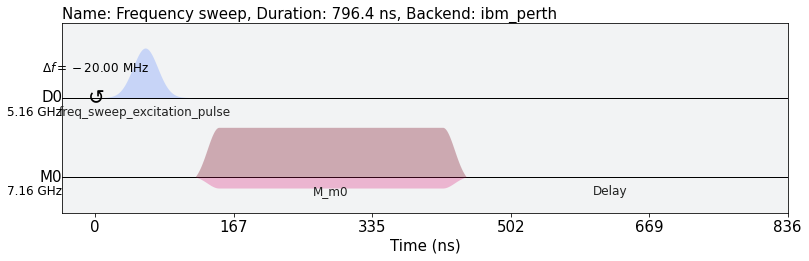

In [30]:
schedules[0].draw(backend=backend) # Draws the pulse sequence we will run

In [31]:
num_shots_per_frequency = 1024 # Number of Shots

job = backend.run(schedules, 
                  meas_level=1, 
                  # If we specify meas_level = 0, we get an array of raw data (an array of complex values per shot)
                  # If we specify meas_level = 1, we get kerneled data, so one complex value per shot
                  # If we specify meas_level = 2, we get classified data (0 or 1)
                  # meas_level = 1 can be used if we want to calibrate the discriminator ourself
                  meas_return='avg', # gives us the avg. of the shots
                  shots=num_shots_per_frequency)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [34]:
# Use job.result() to get the results, note that this can't be called more than once for the same job since the information is already "read" once
frequency_sweep_results = job.result(timeout=0) # timeout specifies how long to wait after job before collecting results, 30 to 120 seconds is a good estimate but 0 also works

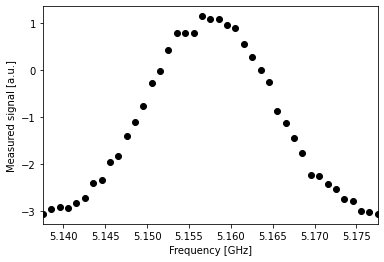

In [35]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [32]:
# As should be seen from the plotted results, the peak corresponds with the drive freq, and there should also be power broadening
# To get the exact value of the peak frequency, we can fit the values to a resonance response shape, so a Lorentzian

In [36]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [37]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial params for curve_fit
                                )

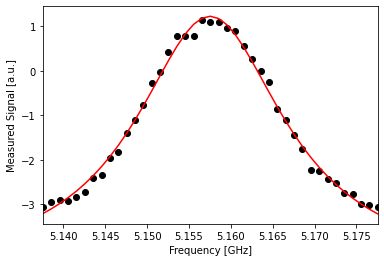

In [38]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [39]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 5.15755 GHz to 5.15751 GHz.


Calibrating π Pulse using a Rabi Experiment

In [40]:
# Now we do an amplitude sweep to find the amplitude for a π Pulse

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [41]:
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

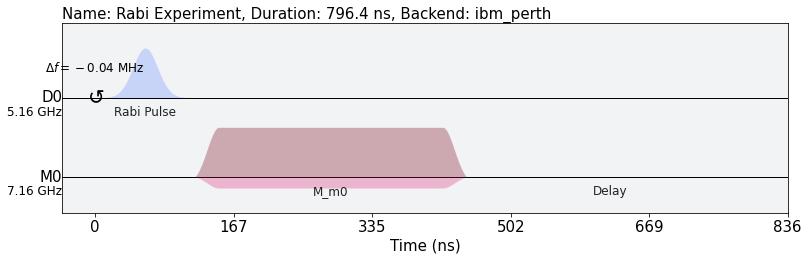

In [42]:
rabi_schedules[-1].draw(backend=backend)

In [43]:
num_shots_per_point = 1024

job = backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [44]:
rabi_results = job.result(timeout=0)

In [48]:
# Now we fit to a sinusoidal curve to determine the amplitude needed for a π Pulse
# Specifically, we want the amplitude to go from a max ( all |0> ) to a min ( all |1> ) state
# So the period/2 gives us the amplitude for a pi pulse

In [45]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

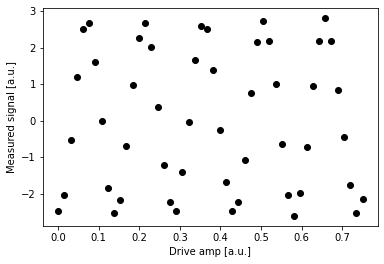

In [46]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

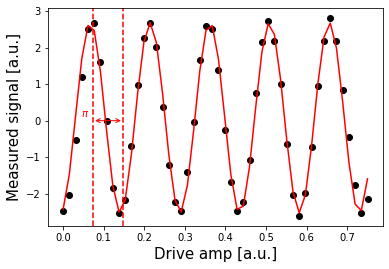

In [62]:
# Very important to note, the curve fitting might not work well unless good estimates are given first
# So if it doesn't work first try, to to roughly approximate values that should work, and then scipy does the rest

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2.7, 0, 0.15, np.pi])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [63]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.07361731917352651


In [64]:
# Now we can define this pi pulse we have found for later

with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

In [65]:
# With a roughly good pi pulse, we can start preparing 0 states and 1 states with good accuracy to collect measurements to make our own discriminator

# Ground state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='ground state') as gnd_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])


# Excited state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])


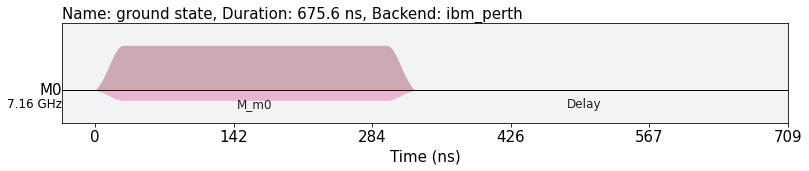

In [66]:
gnd_schedule.draw(backend=backend)

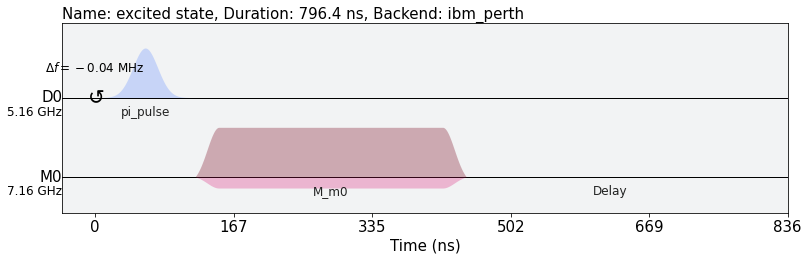

In [67]:
exc_schedule.draw(backend=backend)

In [68]:
# Now we can run the ground schedule and the excited schedule
# Note that when we get kernedled results with meas_level = 1, its kinda like taking a dot product of the complex array of raw results, so still raw but manageable

num_shots = 1024

job = backend.run([gnd_schedule, exc_schedule], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [69]:
gnd_exc_results = job.result(timeout=0)

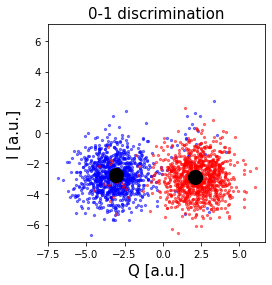

In [70]:
# Now we can plot the results to see what we roughly get

gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure()

# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [71]:
# Then we can set up a very simple classifier by just checking which mean cluster is a given point closer to

import math

def classify(point: complex):
    # Classify the given state as |0> or |1>
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

Measuring T1 using Inversion Recovery

In [72]:
# We can measure T1 by playing a pi pulse, and then varying the time we delay between the pulse and the measurement
# Plotting the results should give us an exponential decay which will give us T1

In [73]:
# T1 experiment parames
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

In [74]:
# Create schedules for the experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T1 delay Experiment") as t1_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

t1_schedules = [t1_schedule.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

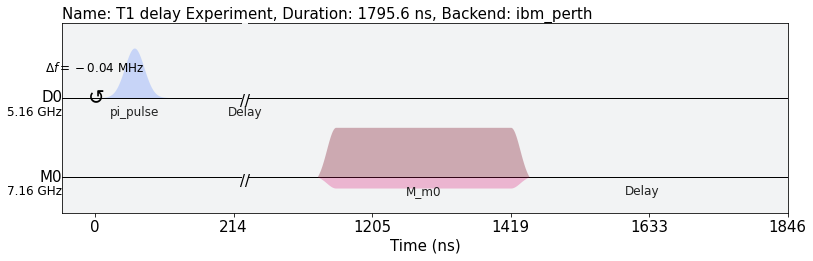

In [79]:
sched_idx = 0 # You can vary this var to see whether the delay is being varied
t1_schedules[sched_idx].draw(backend=backend)

In [80]:
num_shots = 256

job = backend.run(t1_schedules, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [81]:
t1_results = job.result(timeout=0)

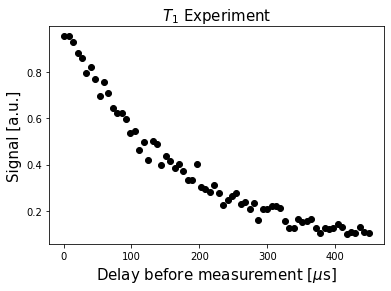

In [82]:
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

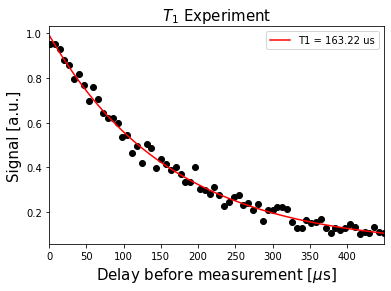

In [83]:
# And now we can fit the data to an exponential to give us T1

fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

Measuring the Qubit Frequency Precisely using a Ramsey Experiment

In [77]:
# We can do this by first applying a pi/2 pulse, waiting time delta t, and then applying another pi/2 pulse
# We should observe oscillations at the difference in frequency between the applied pulses and the qubit

In [84]:
# Note that we will refer to pi/2 as x90, cuz its easier to type

time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive params
drive_amp = pi_amp / 2

with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [85]:
# A trick that is used with Ramsey Experiments is to add a small detuning_MHz to throw the qubit off resonance
# The measured Ramsey signal show now show oscillations with frequency near detuning_MHz, with a small offset
# This small offset is exactly how much our rough_qubit_frequency is from the actual qubit frequency

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [86]:
# So now we vary delta t in this Experiment

delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

ramsey_schedules = [ramsey_schedule.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

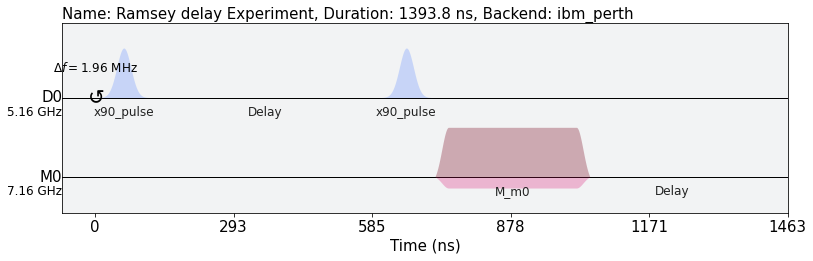

In [88]:
ramsey_id = 15 # try varying this to verify if the delta t does change
ramsey_schedules[ramsey_id].draw(backend=backend)

In [89]:
num_shots = 256

job = backend.run(ramsey_schedules, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [90]:
ramsey_results = job.result(timeout=0)

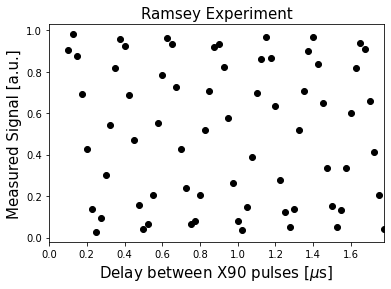

In [91]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

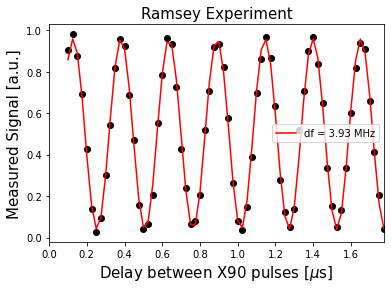

In [93]:
# Now we can fit the data to a sinusoidal and extract the delta frequency which will help us get the qubit frequency
# Very important to note, the curve fitting might not work well unless good estimates are given first
# So if it doesn't work first try, to to roughly approximate values that should work, and then scipy does the rest

fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [0.5, 1./0.27, 0.5, 0.5]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [94]:
# And now we can update the rough_qubit_freqency

precise_qubit_freq = rough_qubit_frequency + (detuning_MHz - del_f_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 5.155576 GHz. It used to be 5.157509 GHz


Measuring T2, Coherence Time, using Hahn Echoes

In [95]:
# Hahn Echoes are quite similar to a Ramsey Experiment, so we still play 2 pi/2 pulses except now there is an additional pi pulse in between
# The pi pulse at time tau reverses the accumulation of phase, and results in an echo at time 2*tau, when we play the second pi/2 pulse for the measurement
# The new decay time from this gives us T2

# T2 experiment parameters
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec = np.arange(2 * us, tau_max_sec, tau_step_sec)

In [96]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2 delay Experiment") as t2_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

t2_schedules = [t2_schedule.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

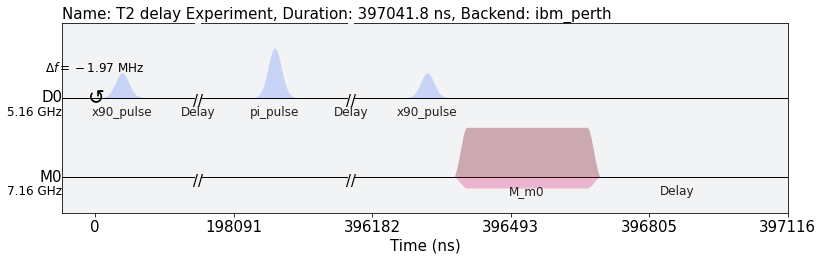

In [97]:
t2_schedules[-1].draw(backend=backend)

In [98]:
num_shots_per_point = 512

job = backend.run(t2_schedules,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [99]:
t2_results = job.result(timeout=0)

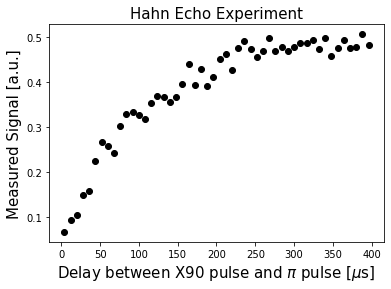

In [100]:
t2_values = []

for i in range(len(delay_times_sec)):
    iq_data = t2_results.get_memory(i)[:,qubit] * scale_factor
    t2_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

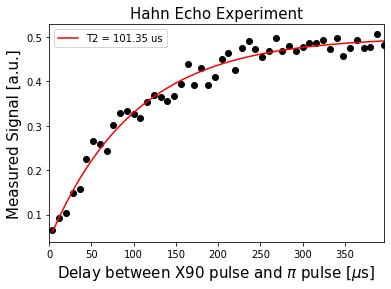

In [101]:
fit_params, y_fit = fit_function(2*delay_times_sec/us, t2_values,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.plot(2*delay_times_sec/us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*delay_times_sec/us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

Dynamical Decoupling

In [126]:
# The following technique is used to cancel out different frequencies of noise, and is used to extract longer T2s from the qubits

# DD experiment params
tau_sec_min = 1 * us
tau_sec_max = 180 * us
tau_step_sec = 4 * us
taus_sec = np.arange(tau_sec_min, tau_sec_max, tau_step_sec)

num_sequence = 1 # apply 1 sequence
print(f"Total time ranges from {2.*num_sequence*taus_sec[0] / us} to {2.*num_sequence*taus_sec[-1] / us} us")

Total time ranges from 2.0 to 354.0 us


In [127]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2DD delay Experiment") as T2DD_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay/2, drive_chan)
    for loop_counts in range(num_sequence):
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        if loop_counts != num_sequence-1:
            pulse.delay(delay, drive_chan)
    pulse.delay(delay/2, drive_chan)
    pulse.call(x90_pulse)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

T2DD_schedules = [T2DD_schedule.assign_parameters({delay: 2*get_dt_from(d/2)}, inplace=False) for d in taus_sec]

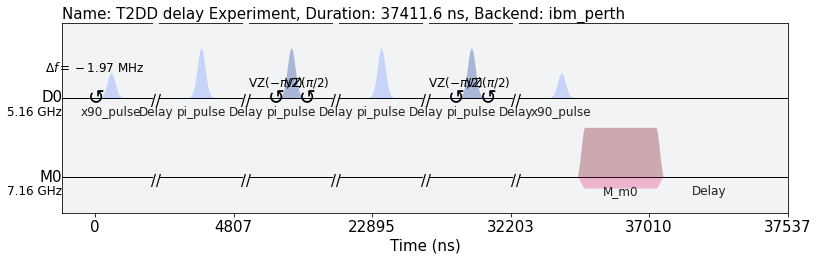

In [128]:
T2DD_schedules[2].draw(backend=backend)

In [129]:
num_shots_per_point = 1024

job = backend.run(T2DD_schedules,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)


job_monitor(job)

Job Status: job has successfully run


In [130]:
T2DD_results = job.result(timeout=0)

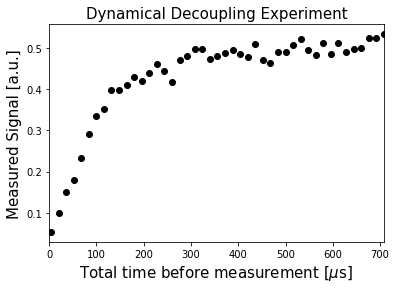

In [131]:
times_sec = 4*num_sequence*taus_sec
DD_values = []

for i in range(len(times_sec)):
    iq_data = T2DD_results.get_memory(i)[:,qubit] * scale_factor
    DD_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(times_sec/us, DD_values, color='black')
plt.xlim(0, np.max(times_sec/us))
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.show()

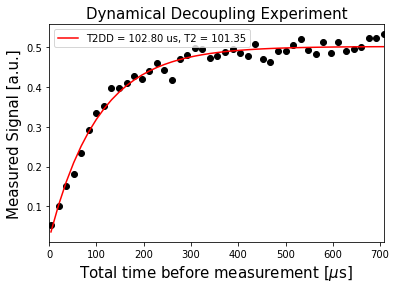

In [132]:
# Fit the data
fit_func = lambda x, A, B, T2DD: (A * np.exp(-x / T2DD) + B)
fitparams, conv = curve_fit(fit_func, times_sec/us, DD_values, [3.5, 0.8, 150])

_, _, T2DD = fitparams
plt.scatter(times_sec/us, DD_values, color='black')
plt.plot(times_sec/us, fit_func(times_sec/us, *fitparams), color='red', label=f"T2DD = {T2DD:.2f} us, T2 = {T2:.2f}")
plt.xlim([0, np.max(times_sec/us)])
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.legend()
plt.show()